# IEOR 222 Final Project: RL on Optimal Order Execution Strategy

# Shun Lin

# 5/11/19

### Background and Goal

### Background

**Reinforcement learning** (RL) is an area of machine learning concerned with how software agents ought to take actions in an environment so as to maximize some notion of cumulative reward. Reinforcement learning is considered as one of three machine learning paradigms, alongside supervised learning and unsupervised learning.

### Diagram for Reinforcement Learning

![alt text](https://www.kdnuggets.com/images/reinforcement-learning-fig1-700.jpg)

**Q-learning** is a model-free reinforcement learning algorithm. The goal of Q-learning is to learn a policy, which tells an agent what action to take under what circumstances. It does not require a model of the environment, and it can handle problems with stochastic transitions and rewards, without requiring adaptations.

### Q-Learning Equation

![alt text](https://cdn-images-1.medium.com/max/1600/0*q8Dnp4guvDD230if.)

### Goal

The goal of this project is to create use reinforcement learning algorithm, specifically **Q-Learning**, on Optimal Order Execution Strategy. We want to understand what is the relationship between the price impact model defined by Bertsimas & Lo (1998) and the optimal order execution. Although we want to use the stock price's data from the real world (for example Apple's AAPL stock) but we should first synthetize stock price data first using the assumptions from the price impact model and build a reinforcement learning model that will learn the parameters for the price impact model that we defined.

### Bertsimas & Lo (1998) Price Impact Model

This is a discrete time model

$P_t = P_{t-1} + \epsilon_t + \theta S_t$

### Three types of price impact model

1. Linear permanent price impact

  $P_t = P_{t-1} + \epsilon_t + \theta S_t$
  
2. Quadratic temporary price impact

  $P_t = P_{0} + \epsilon_t + \theta_1 S_t + \theta_2 S_t^2 $
  
3. Quadratic permanent price impact

  $P_t = P_{t-1} + \epsilon_t + \theta_1 S_t + \theta_2 S_t^2 $

4. Linear transient price impact

    $P_t = P_0 + \sum_{s=0}^{t}  \epsilon_s + \sum_{s=0}^{t} e^{\alpha(s-t)} \theta_1 S_t  $


In this project, I will use the Q-learning (reinforcement learning) to find the optimal strategy under those price impact models.

### References

1. X.Guo. Optimal placement in a limit order book
2. J. Gatheral. No-dynamic-arbitrage and market impact
3. J. Gatheral. Dynamical models of market Impact and algorithms for order execution
4. B. Bouchard. Optimal control of trading algorithms: a general impulse control approach
5. D. Bertsimas. Optimal control of execution costs

## (0) Setup and Imports

In [0]:
# this cell is for all the imports neede for this notebook
import numpy as np
import random
import math
import copy
import matplotlib.pyplot as plt

import datetime
from dateutil.relativedelta import relativedelta

## (1) Synthetic Price Movements Generation

To synthetize price movements, we are setting $\theta$ and then later have our R.L. model to learn it.

### (1.1) Environment Specification

In [0]:
# This cell contains the parameters for our environment

# learning rate
alpha = 0.9

# theta we trying to learn using RL
theta = 2 * 10 ** -3

# time period of our model
T = 5

# initial price of stock
P_0 = 100

# number of shares we want to sell
total_shares = 5000

For the error term of our equation we will be using the normal gussian noise. ```np.random.normal```

### (1.2) Benchmark (Naive) Approach

The first stimuation we will do is to buy equal amount of share at each time step ($50000 / 10 = 5000$) shares and we will compute the cost that it takes for us to sell 100000 shares using this approach.

In [222]:
cost = 0

# initiailze P_t to be the initial price
P_t = P_0

for i in range(T):
    
    # update the price of the stock base on the linear price impact model
    noise = np.random.normal()
    P_t = P_t + noise + theta * -((total_shares / T))
    
    # add the cost of purchasing shares
    cost += P_t * (total_shares / T)

print("Total price of selling 5,000 shares: $%.2f" % cost)
print("Average price per share: $%.2f" % (cost / total_shares))

Total price of selling 5,000 shares: $548928.08
Average price per share: $91.49


Now let's stimute many naive approach and plot out the graph to see the relationship of linear price impact.

In [0]:
# this is a helper function for naive solution
def naive_solution(P_0, total_shares, T):
    
    cost = 0
    
    # initiailze P_t to be the initial price
    num_share_per_t = (total_shares / T)
    
    P = [0] * T
    P_t = P_0

    for i in range(T):

        # update the price of the stock base on the linear price impact model
        noise = np.random.normal()
        P_t = P_t + noise + theta * -num_share_per_t
        
        # add the cost of purchasing 5000 shares
        P[i] = P_t
        cost += P_t * num_share_per_t
    
    cost_per_share = cost / total_shares
    return cost_per_share, P

In [0]:
num_stimuation = 10000
costs_per_share = [0] * num_stimuation
Ps = [0] * num_stimuation
for j in range(num_stimuation):
    cost, P = naive_solution(P_0, total_shares, T)
    costs_per_share[j] = cost
    Ps[j] = P

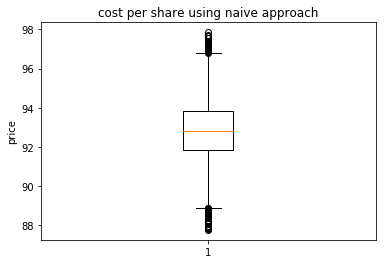

The median cost per share is $92.82


In [225]:
plt.boxplot(costs_per_share)
plt.title("cost per share using naive approach")
plt.ylabel("price")
plt.show()
print("The median cost per share is $%.2f" % np.median(costs_per_share))

As we can see from the graph above, the naive approach (splitting the sale of stock evenly among the 5 period, will incur a profit of \\$92.82 when we run 10000 trials on the same parameters, which is lower than the initial $P_0$ of \$100.

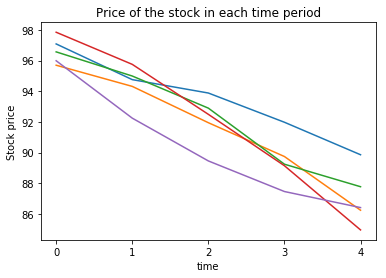

In [226]:
x = np.arange(0, 5)
y = np.asarray(Ps[0:5])
plt.plot(x, y.T)
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.title("Price of the stock in each time period")
plt.ylabel("Stock price")
plt.xlabel("time")
plt.show()


<br/>
<br/>
In the above cell we have plot 5 price changes over the stimuation time period (T=5) and we can see that when we split thesell of the stock price evenly throughout the course of 5 time period the stock price goes down in each time period in expectation due to the linear price impact model. In those stimulations we can see that the effect of the price shock, or the error term, can sometimes upset the effect of the price impact of stock sale and cause the stock price to go up.

## (2) Q-Learning on Linear Price Impact Model

In this section I will stimulate Q-Learning on the simple linear price impact model to find the optimal price execution strategy. In the literature, we are expected to see that the optimal price execution strategy is very similiar to that of naive approach of spliting the purchase evenly among all time period.

In this section, we will assume that the enviornment allows the order to be executed with certainty, thus making the transfer matrix of this problem **deterministic**. If time permits, we will also explore the problem where the order may not be fulfilled and thus making the transition matrix **stochastic**.

The **reward** for this problem is defined **dynamically**. The **reward** is the average price paid per share for the remaining time using optimal strategy compare to the current price.

$P_t = P_{t-1} + \epsilon_t + \theta S_t$

$R(S_{t,w}, A)$ means the action taken at time t with w remining dollar

$R(S_{t,w}, A)= $ number of stock sold $ *$  price of stock

The cell below is learning the Q-matrix by iterating through all the possible selling strategy within the time period (given that we can only sell in thousands and have 5 time period).

In [0]:
'''
inputs definition:
  total_shares is the total amount of shares we want to sell
  P_0 is the initial price
  T is the time period we want to sell the shares we have
  alpha is the constant for learning rate
  theta is the price impact constant
  gamma is the discount rate
  num_iter is the iteration we want to iterate through the possible paths
  
  price_func is a function that takes in the following inputs and output
    the price of stock at next time step
'''
def Q_learning(total_shares, P_0, T, alpha, theta1, theta2, gamma, num_iter, price_func):
  
  start_time = datetime.datetime.now()

  # in each time step an agent can sell a multiple of 1000s of share of the stock
  # but at the end of T=10 the agent most have 5000 stocks sold
  actions = np.arange(0, int(total_shares / 1000 + 1))
  
  # the states are defined as time and the remining stock that we need to purchase
  # the columns index of the states indicates time and the row index of the states
  # indicates the amount remaining
  # states[i][j] means that at time i, there are j * 1000 shares remaind that
  # need to be purchased
  num_col = T
  num_row = total_shares // 1000 + 1
  states = np.zeros((num_col, num_row))

  # initilize the Q matrix, which has the dimension of
  # (num_states, num_actions) and num_states has shape of 
  # (T, total_shares // 1000) and num_actions = num_row
  Q = np.zeros((num_col, num_row, num_row))

  # R is a reward matrix that store the RUNNING AVERAGE reward
  # gathered by the trials
  R = np.zeros_like(Q)

  # counts is a matrix that keep track of the number of time
  # we have receive the reward at a point in R
  # this matrix is for bookkeeping for our RUNNING AVERAGE reward
  counts = np.zeros_like(R)

  num_iter = 1000

  # Q matrix update
  for i in range(num_iter):
      P_t = P_0

      # initial path: don't buy anything until the last time step
      # we will decrement the path backward until we reach a state where
      # we buy everything in the first time step
      # i.e. path[0] = 0
      path = [total_shares // 1000 for i in range(T)]
      # at the last time step the remaining shares to purchase must be 0
      path[-1] = 0

      # this variable is for path generation bookkeeping purpose
      # have another additional - 1 for indexing
      last_modified_time = (T - 1) - 1

      # iterate through each possible path
      while path[0] != -1:    
        # print("===== start of one path =======")
        last_nonzero_index = 0
        # print(path)

        P_t = P_0
        current_stocks_remaining = total_shares // 1000
        # iterate through each time period
        for t in range(T):
          
          stock_sold = current_stocks_remaining - path[t]
          
          # update price
          P_t = price_func(P_t, P_0, theta1, theta2, stock_sold, path, t)
          
          reward_of_this_trial = stock_sold * P_t
          prev_average_reward = R[t][current_stocks_remaining][stock_sold]
          prev_counts = counts[t][current_stocks_remaining][stock_sold]

          reward = (reward_of_this_trial + prev_counts * prev_average_reward) \
            / (prev_counts + 1)

          R[t][current_stocks_remaining][stock_sold] = reward
          counts[t][current_stocks_remaining][stock_sold] += 1

          best_next_q = 0
          next_possible_actions = actions[:path[t]+1]
          # print(next_possible_actions)
          if t < T - 1:
            for next_action in next_possible_actions:
              best_next_q = max(best_next_q, Q[t+1][path[t]][next_action])

          # print(best_next_q)
          original_q = Q[t][current_stocks_remaining][stock_sold]
          Q[t][current_stocks_remaining][stock_sold] = original_q + \
                      alpha * (reward + gamma * best_next_q - original_q)

          current_stocks_remaining = path[t]

          # we sold all our stocks, time to run the next path
          if current_stocks_remaining == 0:
            last_nonzero_index = t - 1
            break

        if last_nonzero_index == -1:
          break

        # print(last_nonzero_index)
        # making new path
        path[last_nonzero_index] -= 1
        for t_to_change in range(last_nonzero_index + 1, T-1):
            path[t_to_change] = path[last_nonzero_index]
            
  end_time = datetime.datetime.now()
  time_diff = diff = relativedelta(end_time, start_time)
  print("The Q-learning for this problem takes %d hours %d minutes %d seconds to compute using Google Colab GPU" 
        % (time_diff.hours, time_diff.minutes, time_diff.seconds))
  return Q

    

In [230]:
# definnition of linear permanent price impact model
# we do not use theta2 in this function becaue we are doing linear permanent
# price impact model
def linear_permanent_impact(current_price, P_0, theta1, theta2, num_shares, path, t):
  noise = np.random.normal()
  next_price = current_price + noise + theta1 * -num_shares * 1000
  return next_price

# learning rate
alpha = 0.99

# future reward discount rate
# when gamma = 1.0 it means that the money we get from selling now
# and selling later is the same, meaning there is no inflation
# we can tune gamma if we believe that there is inflation
# and we want to sell quicker instead of sell later
gamma = 1.0

# theta we trying to learn using RL
theta1 = 2 * 10 ** -3

# theta2 is 0 because we are doing linear price impact
theta2 = 0

# time period of our model
T = 5

# initial price of stock
P_0 = 100

# number of shares we want to sell
total_shares = 5000

# number of iteration we want to go through with Q learning
num_iter = 1000

# use the linear permanent price impact model
price_func = linear_permanent_impact

# learn Q
Q = Q_learning(total_shares, P_0, T, alpha, theta1, theta2, gamma, num_iter, price_func)

The Q-learning for this problem takes 0 hours 0 minutes 5 seconds to compute using Google Colab GPU


### (2.1) Translate Q-matrix to Optimal Selling Strategy

Now that we have learned a Q-matrix, let's define a method that will translate the Q-matrix into the optimal selling strategy. This is simple, as the optimal selling strategy (action) of a given state is just the argmax of the associated state in the Q-matrix (argmax over all the possible actions).

In [0]:
def Q_matrix_to_strategy(Q):
  
  total_time = len(Q)
  total_num_shares_to_sell = len(Q[0]) - 1
  print("====== Q-matrix analysis begin ======")
  print()
  print("Have {} time period to sell {},000 shares.\n"
        .format(total_time, total_num_shares_to_sell))
  print("Optimal strategy based on the learned Q-matrix:")
  num_stocks_left = total_shares // 1000
  for t in range(total_time):
    num_shares_to_sell = np.argmax(Q[t][num_stocks_left])
    print("at t={} sell {},000 shares"
          .format(t+1, num_shares_to_sell))
    num_stocks_left -= num_shares_to_sell
  
  print()
  print("====== Q-matrix analysis finish ======")

In [232]:
Q_matrix_to_strategy(Q)

====== Q-matrix analysis begin ======

Have 5 time period to sell 5,000 shares.

Optimal strategy based on the learned Q-matrix:
at t=1 sell 1,000 shares
at t=2 sell 1,000 shares
at t=3 sell 1,000 shares
at t=4 sell 1,000 shares
at t=5 sell 1,000 shares

====== Q-matrix analysis finish ======


As we can see from the above cell's output, we see that our Q-learning algorithm does indeed find the same optimal strategy of selling share at equal amount at every time step! This finding reinforce further tell us that when the price impact is linear, the optimal strategy is to sell the same amount of shares at each time step!

### (2.2) Recover Theta, $\theta$, from the Q matrix

In this section we will define a method that helps us recover theta from the Q-matrix, assuming that the price impact model is linear and permanent.

In [0]:
# method that returns the recovered theta from Q-matrix computed earlier
# and the initial price of the stock we are trying to sell
def recover_theta_from_q_matrix(Q, P_0):
  total_time = len(Q)
  total_num_shares_to_sell = len(Q[0]) - 1
  num_shares = total_num_shares_to_sell * 1000
  shares_per_time = num_shares / total_time
  
  best_total_profit = np.max(Q[0][total_num_shares_to_sell])
  best_avg_profit = best_total_profit * 1000 / shares_per_time
  diff = best_avg_profit - total_time * P_0
  theta_accumlated = (total_time * (total_time + 1)) / 2
  recovered_theta = -diff / (theta_accumlated * shares_per_time)
  return recovered_theta

In [0]:
# helper function to see how far we are off 
# from the recovered theta we found vs the real theta
def percentage_error(recovered_theta, theta):
  print("====== Recovered Theta Analysis Start ======\n")
  print("True Theta: {}".format(theta))
  print("Recovered Theta: {}".format(recovered_theta))
  diff = abs(recovered_theta - theta)
  error = diff / theta * 100
  print("Percentage Error: {0:.2f}%".format(error))
  print()
  print("====== Recovered Theta Analysis Ends ======")

In [238]:
recovered_theta = recover_theta_from_q_matrix(Q, P_0)
percentage_error(recovered_theta, theta)

====== Recovered Theta Analysis Start ======

True Theta: 0.002
Recovered Theta: 0.002000806097212156
Percentage Error: 0.04%

====== Recovered Theta Analysis Ends ======


As we can see from the cell output above, we have successfully recovered the theta, $\theta$ from the Q-matrix that we computed before. The theta is unknown for us before but by analyizing the Q-matrix and do processing from values stored within the Q-matrix we are able to recover the unknown theta through Q-learning!

### (2.3) Test Our Q-Learning Model works with other settings

In this section, I want to further test our functionality of `Q_learning` and `Q_matrix_to_strategy` method that I have defined with other settings to make sure that I did not hard-code anything when I implment those methods.

In [239]:
# learning rate
alpha = 0.99

# future reward discount rate
# when gamma = 1.0 it means that the money we get from selling now
# and selling later is the same, meaning there is no inflation
# we can tune gamma if we believe that there is inflation
# and we want to sell quicker instead of sell later
gamma = 1.0

# theta we trying to learn using RL
theta1 = 2 * 10 ** -3

# theta2 is 0 because we are doing linear price impact
theta2 = 0

# time period of our model
T = 5

# initial price of stock
P_0 = 100

# number of shares we want to sell
total_shares = 10000

# number of iteration we want to go through with Q learning
num_iter = 10

# use the linear permanent price impact model
price_func = linear_permanent_impact

# learn Q
Q = Q_learning(total_shares, P_0, T, alpha, theta1, theta2, gamma, num_iter, price_func)

The Q-learning for this problem takes 0 hours 0 minutes 51 seconds to compute using Google Colab GPU


As we can see from the output of the cell above, when we increase the actions space (i.e. increase the total number of shares we can to sell) we increase the time to compute the Q-matrix exponentially. 

In [240]:
Q_matrix_to_strategy(Q)

====== Q-matrix analysis begin ======

Have 5 time period to sell 10,000 shares.

Optimal strategy based on the learned Q-matrix:
at t=1 sell 2,000 shares
at t=2 sell 2,000 shares
at t=3 sell 2,000 shares
at t=4 sell 2,000 shares
at t=5 sell 2,000 shares

====== Q-matrix analysis finish ======


As we can see from the output from the cell above, our Q-learning model is still able to learn the correct and optimal strategy of selling shares in equal amount through out the time period.

In [241]:
recovered_theta = recover_theta_from_q_matrix(Q, P_0)
percentage_error(recovered_theta, theta)

====== Recovered Theta Analysis Start ======

True Theta: 0.002
Recovered Theta: 0.002000138734310995
Percentage Error: 0.01%

====== Recovered Theta Analysis Ends ======


As we can see from the output from the cell above, our Q-learning model is still able to learn the correct theta! Meaning that through looking at the value in Q-matrix we are able to recover the theta, which is the price impact, on selling the shares we own.

In [135]:
# learning rate
alpha = 0.99

# future reward discount rate
# when gamma = 1.0 it means that the money we get from selling now
# and selling later is the same, meaning there is no inflation
# we can tune gamma if we believe that there is inflation
# and we want to sell quicker instead of sell later
gamma = 1.0

# theta we trying to learn using RL
theta1 = 2 * 10 ** -3

# theta2 is 0 because we are doing linear price impact
theta2 = 0

# time period of our model
T = 8

# initial price of stock
P_0 = 100

# number of shares we want to sell
total_shares = 8000

# number of iteration we want to go through with Q learning
num_iter = 2

# use the linear permanent price impact model
price_func = linear_permanent_impact

# learn Q
Q = Q_learning(total_shares, P_0, T, alpha, theta1, theta2, gamma, num_iter, price_func)

The Q-learning for this problem takes 0 hours 8 minutes 12 seconds to compute using Google Colab GPU


As we can see from above cell output, the time for my implmentation of Q-learning on this problem takes 7 minutes on GPU! As we can see that when we increase the time period T and total shares we want to sell, the time to compute the problem becomes long, but it still works! See the below cell output.

In [136]:
Q_matrix_to_strategy(Q)

====== Q-matrix analysis begin ======

Have 8 time period to sell 8,000 shares.

Optimal strategy based on the learned Q-matrix:
at t=1 sell 1,000 shares
at t=2 sell 1,000 shares
at t=3 sell 1,000 shares
at t=4 sell 1,000 shares
at t=5 sell 1,000 shares
at t=6 sell 1,000 shares
at t=7 sell 1,000 shares
at t=8 sell 1,000 shares

====== Q-matrix analysis finish ======


As we can see from the cell output from above, our Q-learning model still able to come out with the optimal strategy in selling the shares we own even when it takes a long time to compute! 

In [137]:
recovered_theta = recover_theta_from_q_matrix(Q, P_0)
percentage_error(recovered_theta, theta)

====== Recovered Theta Analysis Start ======

True Theta: 0.002
Recovered Theta: 0.0019997647601037523
Percentage Error: 0.01%

====== Recovered Theta Analysis Ends ======


As we can see from the cell output from above, we are still able to recover our theta from this problem to a very accurate degree even when the problem takes a long time to compute, this further prove that by using the Q-matrix and Q-learning we are able to not just find the optimal strategy in the linear permanent price impact model but also the theta value.

### (2.4) Result of Using Q-learning on Linear Permanent Price Impact Model

As we can see from the above, the Q-learning algorithm is able to allow us to both find the optimal selling strategy (and with even more generalization to our algorithm we can also include the optimal buying strategy) and also learned the unknown theta. The resulting optimal strategy of Q-learning on linear permanent price impact model further proved that the best way to buy/sell a large number of shares is to split them equally throughout the time period that we have to trade the stock. For even in our first enviornment, the optimal strategy for selling 5,000 shares in 5 time period is to sell 1,000 shares at each time period.

## (3) Q-learning on Quadratic Temporary Price Impact

In this section, we will define the quadratic impact function and use the Q-learning method we have developed above to see what the optimal strategy is under quadratic temporary price impact and also try to recover the unknown parameter $\theta_1$ and $\theta_2$ if possible.

Quadratic temporary Price Impact Price Change Formula 

$P_t = P_{0} + \epsilon_t + \theta_1 S_t + \theta_2 S_t^2 $

As you can see from this formula, the $\theta_1$ term is the term for the linear price impact and the $\theta_2$ is the term for the quadratic price impact. Since we are dealing with quadratic term, we need to be really careful in choosing our $\theta_2$ term as in our problem definition we are dealing in thousands of shares and thus the squared term can really affect the price of the share.


### (3.1) Synthetic Price Movements Generation for Quadratic Temporary Case

In this section we will define a naive approach similiar to how to do it for the linear temporary price impact case and see how the price change when we sell shares at equal interval through the time allowed.

In [0]:
# this is a helper function for naive solution
def naive_solution(P_0, total_shares, theta1, theta2, T):
    
    cost = 0
    
    # initiailze P_t to be the initial price
    s_t = (total_shares / T)
    
    P = [0] * T
    P_t = P_0

    for i in range(T):
        # update the price of the stock base on the quad temp price model
        noise = np.random.normal()
        P_t = P_0 + noise + -(theta1 * s_t + theta2 * s_t ** 2)
        
        # add the cost of purchasing 5000 shares
        P[i] = P_t
        cost += P_t * s_t
    
    cost_per_share = cost / total_shares
    return cost_per_share, P

In [0]:
# theta1 for the linear term of price impact
theta1 = 1 * 10 ** -3

# theta2 for the quad term  of price impact
theta2 = 1 * 10 ** -7

# learning rate
alpha = 0.9

# time period of our model
T = 5

# initial price of stock
P_0 = 100

# number of shares we want to sell
total_shares = 5000

num_stimuation = 10000
costs_per_share = [0] * num_stimuation
Ps = [0] * num_stimuation
for j in range(num_stimuation):
    cost, P = naive_solution(P_0, total_shares, theta1, theta2, T)
    costs_per_share[j] = cost
    Ps[j] = P

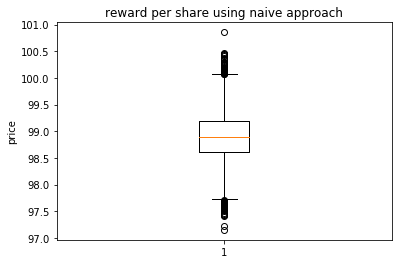

The median reward per share is $98.90


In [260]:
plt.boxplot(costs_per_share)
plt.title("reward per share using naive approach")
plt.ylabel("price")
plt.show()
print("The median reward per share is $%.2f" % np.median(costs_per_share))

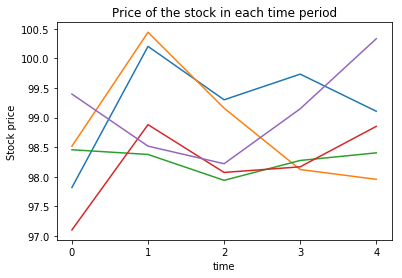

In [261]:
x = np.arange(0, 5)
y = np.asarray(Ps[0:5])
plt.plot(x, y.T)
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.title("Price of the stock in each time period")
plt.ylabel("Stock price")
plt.xlabel("time")
plt.show()

As we can see from the graph above, the quadratic temporary price impact model will have the stock price jump high in the first time step, and then stay relatively the same after because the price impact is termporary and not permanent, so if we do not sell shares in one time step the price will fall back to $P_0$ as we have expected from the formula above. The figure above used the naive, sell the same amount of share at each time period and thus the temporary price impact stay the same and thus $P_t$ also stay relatively the same throughout the course of the trading periods after the first time step.

### (3.2) Using Q-Learning Algorithm to solve the optimal strategy for quadratic temporary impact case

In [268]:
# definnition of quadratic permanent price impact model
def quad_temp_impact(current_price, P_0, theta1, theta2, num_shares, path, t):
  noise = np.random.normal()
  s_t = num_shares * 1000
  next_price = P_0 + noise + -(theta1 * s_t + theta2 * s_t ** 2)
  return next_price

# learning rate
alpha = 0.99

# future reward discount rate
# when gamma = 1.0 it means that the money we get from selling now
# and selling later is the same, meaning there is no inflation
# we can tune gamma if we believe that there is inflation
# and we want to sell quicker instead of sell later
gamma = 1.0

# theta1 for the linear term of price impact
theta1 = 5 * 10 ** -3

# theta2 for the quad term  of price impact
theta2 = 1 * 10 ** -6

# time period of our model
T = 5

# initial price of stock
P_0 = 100

# number of shares we want to sell
total_shares = 5000

# number of iteration we want to go through with Q learning
num_iter = 1000

# use the linear permanent price impact model
price_func = quad_temp_impact

# learn Q
Q = Q_learning(total_shares, P_0, T, alpha, theta1 ,theta2, gamma, num_iter, price_func)

The Q-learning for this problem takes 0 hours 0 minutes 5 seconds to compute using Google Colab GPU


In [269]:
Q_matrix_to_strategy(Q)

====== Q-matrix analysis begin ======

Have 5 time period to sell 5,000 shares.

Optimal strategy based on the learned Q-matrix:
at t=1 sell 1,000 shares
at t=2 sell 1,000 shares
at t=3 sell 1,000 shares
at t=4 sell 1,000 shares
at t=5 sell 1,000 shares

====== Q-matrix analysis finish ======


As we can see from the above cell output, the optimal strategy of the quadratic temporary price impact model is the same as linear permanent price impact model case, sell stocks evenly across the time period. This makes sense as the price impact is temporary and thus in order to minimize the negative price impact of the sale we want to spread out the sale of stocks throughout the period we want. This will maximize the profit we will get by selling shares under the assumption of the quadratic temporary price model. Very interesting!

### (3.3) More Examples using Q-learning on Quadratic Temporary Price Impact to test the optimal strategy

In this section we are going to make more examples using the Q-learning on Quadratic temporary price impact to see if the optimal strategy for quadratic temporary price impact is the same (selling shares with equal amount at each time step).

In [295]:
# learning rate
alpha = 0.99

# future reward discount rate
# when gamma = 1.0 it means that the money we get from selling now
# and selling later is the same, meaning there is no inflation
# we can tune gamma if we believe that there is inflation
# and we want to sell quicker instead of sell later
gamma = 1.0

# theta we trying to learn using RL
theta1 = 2 * 10 ** -3

# theta2 is 0 because we are doing linear price impact
theta2 = 2 * 10 ** -6

# time period of our model
T = 5

# initial price of stock
P_0 = 1000

# number of shares we want to sell
total_shares = 10000

# number of iteration we want to go through with Q learning
num_iter = 10

# use the linear permanent price impact model
price_func = quad_temp_impact

# learn Q
Q = Q_learning(total_shares, P_0, T, alpha, theta1, theta2, gamma, num_iter, price_func)

The Q-learning for this problem takes 0 hours 0 minutes 50 seconds to compute using Google Colab GPU


In [298]:
Q_matrix_to_strategy(Q)

====== Q-matrix analysis begin ======

Have 5 time period to sell 10,000 shares.

Optimal strategy based on the learned Q-matrix:
at t=1 sell 2,000 shares
at t=2 sell 2,000 shares
at t=3 sell 2,000 shares
at t=4 sell 2,000 shares
at t=5 sell 2,000 shares

====== Q-matrix analysis finish ======


As we can see from the cell output above, the optimal strategy for selling 10,000 shares in 5 time period under the quadratic temporary price impact model is the same as expected, sell 2,000 shares at each time period!

In [299]:
# learning rate
alpha = 0.99

# future reward discount rate
# when gamma = 1.0 it means that the money we get from selling now
# and selling later is the same, meaning there is no inflation
# we can tune gamma if we believe that there is inflation
# and we want to sell quicker instead of sell later
gamma = 1.0

# theta we trying to learn using RL
theta1 = 2 * 10 ** -3

# theta2 is 0 because we are doing linear price impact
theta2 = 2 * 10 ** -5

# time period of our model
T = 7

# initial price of stock
P_0 = 1000

# number of shares we want to sell
total_shares = 7000

# number of iteration we want to go through with Q learning
num_iter = 10

# use the linear permanent price impact model
price_func = quad_temp_impact

# learn Q
Q = Q_learning(total_shares, P_0, T, alpha, theta1, theta2, gamma, num_iter, price_func)

The Q-learning for this problem takes 0 hours 1 minutes 50 seconds to compute using Google Colab GPU


In [300]:
Q_matrix_to_strategy(Q)

====== Q-matrix analysis begin ======

Have 7 time period to sell 7,000 shares.

Optimal strategy based on the learned Q-matrix:
at t=1 sell 1,000 shares
at t=2 sell 1,000 shares
at t=3 sell 1,000 shares
at t=4 sell 1,000 shares
at t=5 sell 1,000 shares
at t=6 sell 1,000 shares
at t=7 sell 1,000 shares

====== Q-matrix analysis finish ======


As we can see from the cell output above, the optimal strategy for selling 7,000 shares in 7 time period under the quadratic temporary price impact model is the same as expected, sell 1,000 shares at each time period! Those additional examples further tell us that the optimal strategy under the  quadratic termporary price impact model is to sell the same amount of shares at each time period regardless of parameters.

### (3.4) Result of Using Q-learning on Quadratic Temporary Price Impact Model

As we can see from the above, the Q-learning algorithm is able to allow us to find the optimal selling strategy (and with even more generalization to our algorithm we can also include the optimal buying strategy). The resulting optimal strategy of Q-learning on quadratic termporary price impact model further proved that the best way to buy/sell a large number of shares is to split them equally throughout the time period that we have to trade the stock. For even in our first enviornment, the optimal strategy for selling 5,000 shares in 5 time period is to sell 1,000 shares at each time period. This result is very interesting as this is the same result we would have gotten from Linear Permanent Price Impact model as we can see from section 2 of this notebook!

## (4) Q-learning on Quadratic Permanent Price Impact

In this section, we will define the quadratic impact function and use the Q-learning method we have developed above to see what the optimal strategy is under quadratic permanent price impact and also try to recover the unknown parameter $\theta_1$ and $\theta_2$ if possible.

Quadratic Permanent Price Impact Price Change Formula 

$P_t = P_{t-1} + \epsilon_t + \theta_1 S_t + \theta_2 S_t^2 $

As you can see from this formula, the $\theta_1$ term is the term for the linear price impact and the $\theta_2$ is the term for the quadratic price impact. Since we are dealing with quadratic term, we need to be really careful in choosing our $\theta_2$ term as in our problem definition we are dealing in thousands of shares and thus the squared term can really affect the price of the share.

### (4.1) Synthetic Price Movements Generation for Quadratic Permanent Case

In this section we will define a naive approach similiar to how to do it for the linear permanent price impact case and see how the price change when we sell shares at equal interval through the time allowed.

In [0]:
# this is a helper function for naive solution
def naive_solution(P_0, total_shares, theta1, theta2, T):
    
    cost = 0
    
    # initiailze P_t to be the initial price
    s_t = (total_shares / T)
    
    P = [0] * T
    P_t = P_0

    for i in range(T):
        # update the price of the stock base on the linear price impact model
        noise = np.random.normal()
        P_t = P_t + noise + -(theta1 * s_t + theta2 * s_t ** 2)
        
        # add the cost of purchasing 5000 shares
        P[i] = P_t
        cost += P_t * s_t
    
    cost_per_share = cost / total_shares
    return cost_per_share, P

In [0]:
# theta1 for the linear term of price impact
theta1 = 1 * 10 ** -3

# theta2 for the quad term  of price impact
theta2 = 1 * 10 ** -6

# learning rate
alpha = 0.9

# time period of our model
T = 5

# initial price of stock
P_0 = 100

# number of shares we want to sell
total_shares = 5000

num_stimuation = 10000
costs_per_share = [0] * num_stimuation
Ps = [0] * num_stimuation
for j in range(num_stimuation):
    cost, P = naive_solution(P_0, total_shares, theta1, theta2, T)
    costs_per_share[j] = cost
    Ps[j] = P

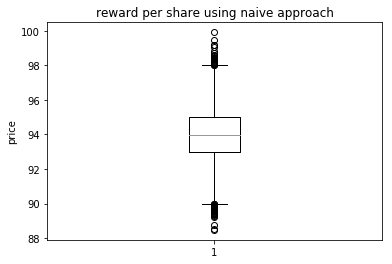

The median reward per share is $93.99


In [274]:
plt.boxplot(costs_per_share)
plt.title("reward per share using naive approach")
plt.ylabel("price")
plt.show()
print("The median reward per share is $%.2f" % np.median(costs_per_share))

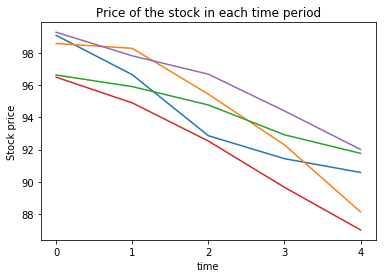

In [275]:
x = np.arange(0, 5)
y = np.asarray(Ps[0:5])
plt.plot(x, y.T)
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.title("Price of the stock in each time period")
plt.ylabel("Stock price")
plt.xlabel("time")
plt.show()

As we can see from the figure above, the quadatric term have a really high impact on the price of the stock as the quadratic term will overwhelm the linear term (if $\theta_2$ is too high) and will make the price decrease more than the one in the linear permanent price impact model.

### (4.2) Using Q-Learning Algorithm to solve the optimal strategy for quadratic impact case

In [293]:
# definnition of quadratic permanent price impact model
def quad_permanent_impact(current_price, P_0, theta1, theta2, num_shares, path, t):
  noise = np.random.normal()
  s_t = num_shares * 1000
  next_price = current_price + noise + -(theta1 * s_t + theta2 * s_t ** 2)
  return next_price

# learning rate
alpha = 0.99

# future reward discount rate
# when gamma = 1.0 it means that the money we get from selling now
# and selling later is the same, meaning there is no inflation
# we can tune gamma if we believe that there is inflation
# and we want to sell quicker instead of sell later
gamma = 1.0

# theta1 for the linear term of price impact
theta1 = 1 * 10 ** -3

# theta2 for the quad term  of price impact
theta2 = 1 * 10 ** -7

# time period of our model
T = 5

# initial price of stock
P_0 = 1000

# number of shares we want to sell
total_shares = 10000

# number of iteration we want to go through with Q learning
num_iter = 100

# use the linear permanent price impact model
price_func = quad_permanent_impact

# learn Q
Q = Q_learning(total_shares, P_0, T, alpha, theta1 ,theta2, gamma, num_iter, price_func)

The Q-learning for this problem takes 0 hours 0 minutes 50 seconds to compute using Google Colab GPU


In [294]:
Q_matrix_to_strategy(Q)

====== Q-matrix analysis begin ======

Have 5 time period to sell 10,000 shares.

Optimal strategy based on the learned Q-matrix:
at t=1 sell 2,000 shares
at t=2 sell 2,000 shares
at t=3 sell 2,000 shares
at t=4 sell 2,000 shares
at t=5 sell 2,000 shares

====== Q-matrix analysis finish ======


Interestingly, the optimal strategy under the quadratic permanent price impact assumption also give us the optimal strategy of selling shares with the same amount at each time step! As we can see from the cell output from above, the optimal strategy for selling 10,000 shares in 5 time period is to sell 2,000 shares in each of the time step. But this result may be due to how we have set our parameter $\theta_1$ and $\theta_2$. In the following section we will try other paremeters to see if we can get different results! If we get different result using different parameters this will mean that in quadratic permanent price impact model the parameters matter in terms of getting the optimal strategy.

In [301]:
# learning rate
alpha = 0.99

# future reward discount rate
# when gamma = 1.0 it means that the money we get from selling now
# and selling later is the same, meaning there is no inflation
# we can tune gamma if we believe that there is inflation
# and we want to sell quicker instead of sell later
gamma = 1.0

# theta1 for the linear term of price impact
theta1 = 1 * 10 ** -3

# theta2 for the quad term  of price impact
theta2 = 1 * 10 ** -6

# time period of our model
T = 5

# initial price of stock
P_0 = 1000

# number of shares we want to sell
total_shares = 10000

# number of iteration we want to go through with Q learning
num_iter = 100

# use the linear permanent price impact model
price_func = quad_permanent_impact

# learn Q
Q = Q_learning(total_shares, P_0, T, alpha, theta1 ,theta2, gamma, num_iter, price_func)

The Q-learning for this problem takes 0 hours 0 minutes 50 seconds to compute using Google Colab GPU


In [302]:
Q_matrix_to_strategy(Q)

====== Q-matrix analysis begin ======

Have 5 time period to sell 10,000 shares.

Optimal strategy based on the learned Q-matrix:
at t=1 sell 1,000 shares
at t=2 sell 2,000 shares
at t=3 sell 2,000 shares
at t=4 sell 2,000 shares
at t=5 sell 3,000 shares

====== Q-matrix analysis finish ======


As we can see from the cell output from above, the optimal strategy of selling 10,000 shares across 5 time period is to sell 1,000 share in the first time step, sell 2,000 shares each in time 2 to 4, and then sell 3,000 shares in the last time step. This result is different than the one we have above because we have changed the value of $\theta_2$ by a factor of 10. This example implies that the optimal strategy of selling shares under the quadratic permanent price impact model is dependent on the parameters we choose!

### (4.3) More Examples using Q-learning on Quadratic Permanent Price Impact to test the optimal strategy

In this section we are going to make more examples using the Q-learning on Quadratic temporary price impact to see if the optimal strategy for quadratic permanent price impact is the dependent on parameters and not necessary selling the same amount of shares at each time period.

In [309]:
# learning rate
alpha = 0.99

# future reward discount rate
# when gamma = 1.0 it means that the money we get from selling now
# and selling later is the same, meaning there is no inflation
# we can tune gamma if we believe that there is inflation
# and we want to sell quicker instead of sell later
gamma = 1.0

# theta1 for the linear term of price impact
theta1 = 1 * 10 ** -3

# theta2 for the quad term  of price impact
theta2 = 1 * 10 ** -5

# time period of our model
T = 7

# initial price of stock
P_0 = 1000

# number of shares we want to sell
total_shares = 7000

# number of iteration we want to go through with Q learning
num_iter = 100

# use the linear permanent price impact model
price_func = quad_permanent_impact

# learn Q
Q = Q_learning(total_shares, P_0, T, alpha, theta1 ,theta2, gamma, num_iter, price_func)

The Q-learning for this problem takes 0 hours 1 minutes 48 seconds to compute using Google Colab GPU


In [313]:
Q_matrix_to_strategy(Q)

====== Q-matrix analysis begin ======

Have 7 time period to sell 7,000 shares.

Optimal strategy based on the learned Q-matrix:
at t=1 sell 1,000 shares
at t=2 sell 1,000 shares
at t=3 sell 0,000 shares
at t=4 sell 1,000 shares
at t=5 sell 1,000 shares
at t=6 sell 1,000 shares
at t=7 sell 2,000 shares

====== Q-matrix analysis finish ======


As we can see from the cell output from above, the optimal strategy of selling 7,000 shares in 7 time period is shown above. As we can see, the strategy is not to sell the same amoutn of stock at each time period, the Q-matrix tells us that we do not sell at time 3 and sell more at time 7. This is due to the quadratic effect of the price impact under this assumption. This example further tell us that the optimal strategy under quadratic permanent price impact assumption is dependent on the parameters we choose.

In [314]:
# learning rate
alpha = 0.99

# future reward discount rate
# when gamma = 1.0 it means that the money we get from selling now
# and selling later is the same, meaning there is no inflation
# we can tune gamma if we believe that there is inflation
# and we want to sell quicker instead of sell later
gamma = 1.0

# theta1 for the linear term of price impact
theta1 = 1 * 10 ** -3

# theta2 for the quad term  of price impact
theta2 = 1 * 10 ** -6

# time period of our model
T = 5

# initial price of stock
P_0 = 1000

# number of shares we want to sell
total_shares = 15000

# number of iteration we want to go through with Q learning
num_iter = 50

# use the linear permanent price impact model
price_func = quad_permanent_impact

# learn Q
Q = Q_learning(total_shares, P_0, T, alpha, theta1 ,theta2, gamma, num_iter, price_func)

The Q-learning for this problem takes 0 hours 3 minutes 45 seconds to compute using Google Colab GPU


In [315]:
Q_matrix_to_strategy(Q)

====== Q-matrix analysis begin ======

Have 5 time period to sell 15,000 shares.

Optimal strategy based on the learned Q-matrix:
at t=1 sell 2,000 shares
at t=2 sell 2,000 shares
at t=3 sell 3,000 shares
at t=4 sell 4,000 shares
at t=5 sell 4,000 shares

====== Q-matrix analysis finish ======


As we can see from the cell output above, the optimal strategy of selling 15,000 shares in 5 time step is selling 2,000 shares in first and second time step, sell 3,000 shares in third time step, and sell 4,000 shares in the last 2 time steps. As we can see again from this example, the optimal strategy under the quadratic permanent price impact model is not selling the same amount of shares at each time period but sell them with different amount in each period, further tell us that the quadratic permanent price impact model is dependent on the parameters we choose!

### (4.4) Result of Using Q-learning on Quadratic Permanent Price Impact Model

As we can see from the above, the Q-learning algorithm is able to allow us to find the optimal selling strategy (and with even more generalization to our algorithm we can also include the optimal buying strategy). The resulting optimal strategy of Q-learning on quadratic permanent price impact model tell us that the optimal strategy under the quadratic permanent price impact assumption is dependent on the parameters we choose. Sometimes the optimal strategy is to sell shares equally across the time steps that we have, other times it is selling different amount of shares at different time period. The result of this section is different from the linear permanent price impact model and quadratic temporary model because the permanent effect on the square of shares sold does have an impact on determine the optimal strategy. Very interesting and finally get to see a price impact that is parameter dependent!

### (5) Q-Learning on Linear Transient Price Impact Model

In this section we will explore how to use Q-learning on linear transient price impact model. Unlike the linear permanent price impact model case, the price of the share at time t is defined as the following:

$P_t = P_0 + \sum_{s=0}^{t}  \epsilon_s + \sum_{s=0}^{t} e^{\alpha(s-t)} \theta_1 S_t  $

As we see from this case, the price impact of the shares we purchased further into the past will give exponentially less impact on the price on current time (we can see this in the last term of the equation above). This is more realistic as the price impact of the shares we sell more into the past should in practice have less impact on the price of the stock today compare to the price impact of the shares we just sell recently.

To implement this, we need to keep track of the number of of shares we sell in each time step.


### (5.1) Synthetic Price Movements Generation for Linear Transient Price Impact Model

In this section we will define a naive approach similiar to how to do it for the linear permanent price impact case and see how the price change when we sell shares at equal interval through the time allowed.

In [0]:
# this is a helper function for naive solution
def naive_solution(P_0, total_shares, theta1, T):
    
    cost = 0
    
    # initiailze P_t to be the initial price
    s_t = (total_shares / T)
    
    P = [0] * T
    P_t = P_0
    sum_noise = 0
    decay = 0.3

    for i in range(T):
        # update the price of the stock base on the linear price impact model
        sum_noise += np.random.normal()
        sum_impact = -sum([np.exp(decay * -j)*theta1*s_t for j in range(i+1)])
        P_t = P_0 + sum_noise + sum_impact
        
        # add the cost of purchasing 5000 shares
        P[i] = P_t
        cost += P_t * s_t
    
    cost_per_share = cost / total_shares
    return cost_per_share, P

In [0]:
# theta1 for the linear term of price impact
theta1 = 2 * 10 ** -3

# learning rate
alpha = 0.9

# time period of our model
T = 10

# initial price of stock
P_0 = 100

# number of shares we want to sell
total_shares = 10000

num_stimuation = 10000
costs_per_share = [0] * num_stimuation
Ps = [0] * num_stimuation
for j in range(num_stimuation):
    cost, P = naive_solution(P_0, total_shares, theta1, T)
    costs_per_share[j] = cost
    Ps[j] = P

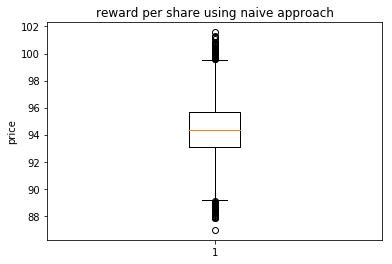

The median reward per share is $94.38


In [379]:
plt.boxplot(costs_per_share)
plt.title("reward per share using naive approach")
plt.ylabel("price")
plt.show()
print("The median reward per share is $%.2f" % np.median(costs_per_share))

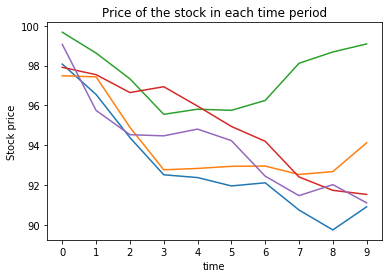

In [380]:
x = np.arange(0, 10)
y = np.asarray(Ps[0:5])
plt.plot(x, y.T)
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.title("Price of the stock in each time period")
plt.ylabel("Stock price")
plt.xlabel("time")
plt.show()

As we can see from the figure above, the decay prevent the price of the stock form falling as fast as in the linear permanent price impact model. But as we can still see from the graph above that the price is still dropping in a sub-linear way in the linear transcient price impact model. In the sections below we will be using Q-learning to try to find the optimal strategy under the linear transcient price impact model assumption.

### (5.2) Using Q-Learning Algorithm to solve the optimal strategy for linear transcient price impact model

In [459]:
# definnition of linear transicent price impact model
# instead of theta2 we will use it as decay
# in this function becaue we are doing linear transient
# price impact model
def linear_trans_impact(current_price, P_0, theta1, decay, num_shares, path, t):
  sum_noise = sum([np.random.normal() for _ in range(t+1)])
  shares_remaining = total_shares // 1000
  sum_impact = 0
  for s in range(t+1):
    s_t = (shares_remaining - path[s]) * 1000
    sum_impact -= np.exp(decay * (s-t)) * theta1 * s_t
    shares_remaining = path[s]
  next_price = P_0 + sum_noise + sum_impact
  return next_price

# learning rate
alpha = 0.99

# future reward discount rate
# when gamma = 1.0 it means that the money we get from selling now
# and selling later is the same, meaning there is no inflation
# we can tune gamma if we believe that there is inflation
# and we want to sell quicker instead of sell later
gamma = 1.0

# theta we trying to learn using RL
theta1 = 5 * 10 ** -3

# theta2 is renamed to decay because we are doing linear transcient model
decay = 0.15

# time period of our model
T = 5

# initial price of stock
P_0 = 10000

# number of shares we want to sell
total_shares = 3000

# number of iteration we want to go through with Q learning
num_iter = 10000

# use the linear permanent price impact model
price_func = linear_trans_impact

# learn Q
Q = Q_learning(total_shares, P_0, T, alpha, theta1, decay, gamma, num_iter, price_func)

The Q-learning for this problem takes 0 hours 0 minutes 2 seconds to compute using Google Colab GPU


In [460]:
Q_matrix_to_strategy(Q)

====== Q-matrix analysis begin ======

Have 5 time period to sell 3,000 shares.

Optimal strategy based on the learned Q-matrix:
at t=1 sell 1,000 shares
at t=2 sell 0,000 shares
at t=3 sell 0,000 shares
at t=4 sell 1,000 shares
at t=5 sell 1,000 shares

====== Q-matrix analysis finish ======


As we can see from the cell output above, the optimal strategy is to sell some stocks in one period, wait some periods, and then sell more stocks. This optimal strategy makes sense as we want to wait out the impact made by the last purchase and then proceed to sell more shares. This optimal strategy is different from the linear permanent price impact model case and also different form the quadratic permanent and quadratic temporary price impact case. This result is very interesting as it shows how waiting out the time before selling other shares in the transient price impact model does help us achieve the best result and optimal strategy.


### (4.3) More Examples using Q-learning on Linear Transicent Price Impact to test the optimal strategy
​
In this section we are going to make more examples using the Q-learning on Linear Transcient price impact to see if the optimal strategy for linear transicent price impact is the dependent on parameters and also see how the length of time affects the our optimal strategy achieved by the Q-learning algorithm.

In [465]:
# learning rate
alpha = 0.99

# future reward discount rate
# when gamma = 1.0 it means that the money we get from selling now
# and selling later is the same, meaning there is no inflation
# we can tune gamma if we believe that there is inflation
# and we want to sell quicker instead of sell later
gamma = 1.0

# theta we trying to learn using RL
theta1 = 5 * 10 ** -2

# theta2 is renamed to decay because we are doing linear transcient model
decay = 0.40

# time period of our model
T = 5

# initial price of stock
P_0 = 10000

# number of shares we want to sell
total_shares = 6000

# number of iteration we want to go through with Q learning
num_iter = 100

# use the linear permanent price impact model
price_func = linear_trans_impact

# learn Q
Q = Q_learning(total_shares, P_0, T, alpha, theta1, decay, gamma, num_iter, price_func)

The Q-learning for this problem takes 0 hours 0 minutes 16 seconds to compute using Google Colab GPU


In [467]:
Q_matrix_to_strategy(Q)

====== Q-matrix analysis begin ======

Have 5 time period to sell 6,000 shares.

Optimal strategy based on the learned Q-matrix:
at t=1 sell 1,000 shares
at t=2 sell 1,000 shares
at t=3 sell 1,000 shares
at t=4 sell 1,000 shares
at t=5 sell 2,000 shares

====== Q-matrix analysis finish ======


In the cell output above we can see that the optimal strategy of selling 6,000 shares in 5 time periods is to sell 1,000 shares each in the first 4 time period and then sell 2,000 shares in the last time period. This makes sense as the optimal strategy as you want to sell more shares later as to let time to offset some of the negative price impact due to earlier sale. This is interesting as we can see that the Q-learning model show us that in the presence of time decay and transicent price impact, we should sell more shares later instead of earlier but also spread out sale of shares through the time period to make sure that the price impact is also migated.

In [494]:
# learning rate
alpha = 0.99

# future reward discount rate
# when gamma = 1.0 it means that the money we get from selling now
# and selling later is the same, meaning there is no inflation
# we can tune gamma if we believe that there is inflation
# and we want to sell quicker instead of sell later
gamma = 1.0

# theta we trying to learn using RL
theta1 = 5 * 10 ** -2

# theta2 is renamed to decay because we are doing linear transcient model
decay = 0.50

# time period of our model
T = 5

# initial price of stock
P_0 = 1000

# number of shares we want to sell
total_shares = 7000

# number of iteration we want to go through with Q learning
num_iter = 20

# use the linear permanent price impact model
price_func = linear_trans_impact

# learn Q
Q = Q_learning(total_shares, P_0, T, alpha, theta1, decay, gamma, num_iter, price_func)

The Q-learning for this problem takes 0 hours 0 minutes 28 seconds to compute using Google Colab GPU


In [495]:
Q_matrix_to_strategy(Q)

====== Q-matrix analysis begin ======

Have 5 time period to sell 7,000 shares.

Optimal strategy based on the learned Q-matrix:
at t=1 sell 1,000 shares
at t=2 sell 1,000 shares
at t=3 sell 1,000 shares
at t=4 sell 2,000 shares
at t=5 sell 2,000 shares

====== Q-matrix analysis finish ======


In the cell output above we can see that the optimal strategy of selling 7,000 shares in 5 time periods is to sell 1,000 shares each in the first three time period and then sell 2,000 shares in the last two time period. This makes sense as the optimal strategy as you want to sell more shares later as to let time to offset some of the negative price impact due to earlier sale. Similiar to the example above where we sell 6,000 shares over 5 time periods, we can see that the Q-learning model show us that in the presence of time decay and transicent price impact, we should sell more shares later instead of earlier but also spread out sale of shares through the time period to make sure that the price impact is also migated.

### (5.4) Result of Using Q-learning on Linear Transcient Price Impact Model

As we can see from the above, the Q-learning algorithm is able to allow us to find the optimal selling strategy (and with even more generalization to our algorithm we can also include the optimal buying strategy). The resulting optimal strategy of Q-learning on linear transcient price impact model tell us that the optimal strategy under the linear transcient price impact assumption is dependent on the parameters we choose and also that the strategy is to sell more shares at the end so to let time "decays" away the negative price impact due to earlier sale of our shaes. The result of this section is different from the linear permanent price impact model and quadratic temporary model because the the transicent and decaying factor we have taken into account into our linear transicent price impact model. Very interesting and finally get to see another price impact that is parameter dependent and also time dependent!

## (6) Fun Experiments with Parameters!



In this experiment I want to see the affect of gamm, i.e. the discount rate, on linear permanent impact.

In [504]:
# definnition of linear permanent price impact model
# we do not use theta2 in this function becaue we are doing linear permanent
# price impact model
def linear_permanent_impact(current_price, P_0, theta1, theta2, num_shares, path, t):
  noise = np.random.normal()
  next_price = current_price + noise + theta1 * -num_shares * 1000
  return next_price

# learning rate
alpha = 0.99

# future reward discount rate
# when gamma = 1.0 it means that the money we get from selling now
# and selling later is the same, meaning there is no inflation
# we can tune gamma if we believe that there is inflation
# and we want to sell quicker instead of sell later
gamma = 0.97

# theta we trying to learn using RL
theta1 = 2 * 10 ** -3

# theta2 is 0 because we are doing linear price impact
theta2 = 0

# time period of our model
T = 5

# initial price of stock
P_0 = 100

# number of shares we want to sell
total_shares = 5000

# number of iteration we want to go through with Q learning
num_iter = 1000

# use the linear permanent price impact model
price_func = linear_permanent_impact

# learn Q
Q = Q_learning(total_shares, P_0, T, alpha, theta1, theta2, gamma, num_iter, price_func)

The Q-learning for this problem takes 0 hours 0 minutes 4 seconds to compute using Google Colab GPU


In [505]:
Q_matrix_to_strategy(Q)

====== Q-matrix analysis begin ======

Have 5 time period to sell 5,000 shares.

Optimal strategy based on the learned Q-matrix:
at t=1 sell 3,000 shares
at t=2 sell 2,000 shares
at t=3 sell 0,000 shares
at t=4 sell 0,000 shares
at t=5 sell 0,000 shares

====== Q-matrix analysis finish ======


Interesting! As we can see from the cell output above, when we change the gamma (discount factor) to 0.97 we see that we want to sell everything at the first two time step. This makes sense as when gamma is less than 1 this means that the future reward worth less than the reward now, meaning that we would want to sell sooner rather than later. We can tune more parameters to play around and see what the optimal strategy will be.

In [506]:
# definnition of linear permanent price impact model
# we do not use theta2 in this function becaue we are doing linear permanent
# price impact model
def linear_permanent_impact(current_price, P_0, theta1, theta2, num_shares, path, t):
  noise = np.random.normal()
  next_price = current_price + noise + theta1 * -num_shares * 1000
  return next_price

# learning rate
alpha = 0.99

# future reward discount rate
# when gamma = 1.0 it means that the money we get from selling now
# and selling later is the same, meaning there is no inflation
# we can tune gamma if we believe that there is inflation
# and we want to sell quicker instead of sell later
gamma = 0.90

# theta we trying to learn using RL
theta1 = 2 * 10 ** -3

# theta2 is 0 because we are doing linear price impact
theta2 = 0

# time period of our model
T = 5

# initial price of stock
P_0 = 100

# number of shares we want to sell
total_shares = 5000

# number of iteration we want to go through with Q learning
num_iter = 1000

# use the linear permanent price impact model
price_func = linear_permanent_impact

# learn Q
Q = Q_learning(total_shares, P_0, T, alpha, theta1, theta2, gamma, num_iter, price_func)

The Q-learning for this problem takes 0 hours 0 minutes 4 seconds to compute using Google Colab GPU


In [507]:
Q_matrix_to_strategy(Q)

====== Q-matrix analysis begin ======

Have 5 time period to sell 5,000 shares.

Optimal strategy based on the learned Q-matrix:
at t=1 sell 5,000 shares
at t=2 sell 0,000 shares
at t=3 sell 0,000 shares
at t=4 sell 0,000 shares
at t=5 sell 0,000 shares

====== Q-matrix analysis finish ======


Interesting! As we can see from the cell output above, when we change the gamma (discount factor) to 0.90 we see that we want to sell everything at the first time step! This makes sense as when gamma is less than 1 this means that the future reward worth less than the reward now, meaning that we would want to sell sooner rather than later.

# Lesson from this Project and Class

I really enjoy this completing this project. Throughout the project I learned techniques of not just about financial engineering but also about programming and machine learning in general. I learned about Q-learning, price impact models, reinforcement learning, general data synthesis and analysis. This project allows me to further digest the knowledge I learned in class by coding up the algorithm and stratgies. Specifically, I learned how to recover the optimal strategy and theta from the unknown parameter using analysis on Q-matrix and the values stored in it.


I also enjoy this class a lot. I really enjoy each lectures and sections as I learned new and chellenging materials each time I walked into class. I really enjoyed the theorical and mathematics concepts taught by Professor Basei and the high frequency trading application taught by Professor Guo. I really appreciate Nan for hosting section each week to clear up any hard to digest concepts taught by professors in class.


Once again, I want to say thank you to Professor Guo, Professor Basei, and Nan for teaching me a lot about financial engineering and high frequency trading through IEOR 221 and IEOR 222.



